<a href="https://colab.research.google.com/github/Jordy-Rodrigues/Deep-Learning/blob/main/Projeto_de_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REDE NEURAL CONVOLUCIONAL - com Pytorch

In [12]:
# IMPORTAR AS BIBLIOTECAS NECESSARIAS
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import  dataset, DataLoader
from torchvision import datasets, transforms

In [13]:
# PRIMEIRO VAMOS TRANSFORMAR AS IMAGENS EM TENSORES E NORMALIZAR 
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, ),(0.5,))])

In [14]:
# BAIXAR DO TorchVision A BASE DE DADOS DE TREINO E TESTE
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download = True,train = True,transform = transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download = True,train = False,transform = transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

In [15]:
# MOSTRAR A QUANTIDADE DE LINHAS DE CADA DATASET
print('train data:', len(train_loader.sampler))
print('test data:', len(test_loader.sampler))

train data: 60000
test data: 10000


In [16]:
# EXAMINAR OS DADOS
dataiter = iter (train_loader)
images, labels = dataiter.next()
# MOSTRAR INFORMAÇÕES
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([100, 1, 28, 28])
torch.Size([100])


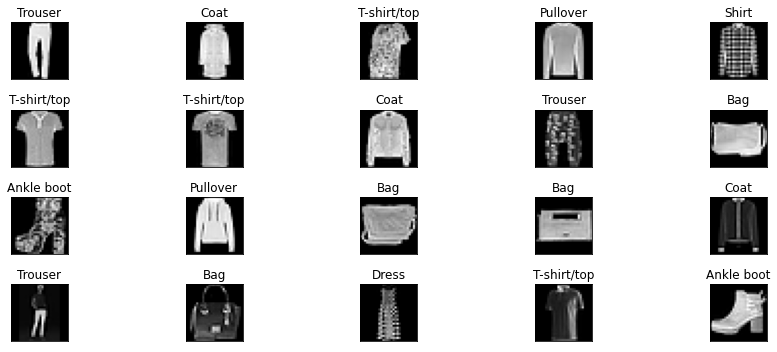

In [17]:
# VISUALIZAR AS IMAGENS DA BASE DE DADOS
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15,5))
rous = 4
columns = 5

fashion_classes= {0: 'T-shirt/top',
                  1: 'Trouser',
                  2: 'Pullover',
                  3: 'Dress',
                  4: 'Coat',
                  5: 'Sandal',
                  6: 'Shirt',
                  7: 'Sneaker',
                  8: 'Bag',
                  9: 'Ankle boot'}

for idx in np.arange(20):
  ax = fig.add_subplot(rous ,columns,idx +1,xticks=[],yticks=[])
  ax.imshow(images[idx].numpy().squeeze(),cmap='gray')
  ax.set_title(fashion_classes[labels[idx].item()])
  fig.tight_layout()

In [18]:
# MONTAR A ARQUITETURA DA REDE
from torch import nn, optim
import torch.nn.functional as F

class modelo (nn.Module):
  def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(784,256)
      self.fc2 = nn.Linear(256,128)
      self.fc3 = nn.Linear(128,64)
      self.fc4 = nn.Linear(64,10)

  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x),dim=1)

    return x

In [19]:
model = modelo()
# DEFINIDO A FUNÇAO LOSS E O OTIMIZADOR
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [20]:
min_validation_loss = np.inf
epochs = 15
#PREPARAR O MODELO PARA TREINAR
train_loss_list, validation_loss_list = [],[]

for epoch in range(epochs):
  model.train()
  running_loss = 0
  validation_loss = 0

# TREINAR O MODELO
  for images, labels in train_loader:
    optimizer.zero_grad()
    log_probs = model(images)
    loss = criterion(log_probs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*images.size(0)

  model.eval()
  with torch.no_grad():
      total = 0
      correct = 0
# TESTAR O MODELO
      for images, labels in test_loader:
        log_probs = model(images)
        loss = criterion(log_probs, labels)
        validation_loss += loss.item()*images.size(0)
        max_class = torch.argmax(log_probs,dim=1)
        total += labels.numel()
        correct += sum(max_class==labels).item()

print("Acurácia de teste:{:.2f}%".format(correct / total * 100))

running_loss = running_loss / len(train_loader.sampler)
validation_loss = validation_loss / len(test_loader.sampler)

train_loss_list.append(running_loss)
validation_loss_list.append(validation_loss)

print("Epoch:{}/{}:".format(epoch+1,epochs),
      "Loss Treino:{:.6f}..".format(running_loss),
      "Loss Validação:{:.6f}..".format(validation_loss))

if validation_loss <= min_validation_loss:
  print('validation loss anterior {}--> validation loss novo {}.Salvando modelo.'.format(min_validation_loss,validation_loss))
  torch.save(model.state_dict(), 'modelo.pth')
  min_validation_loss = validation_loss

  print()

Acurácia de teste:88.37%
Epoch:15/15: Loss Treino:0.244272.. Loss Validação:0.327549..
validation loss anterior inf--> validation loss novo 0.3275490967929363.Salvando modelo.



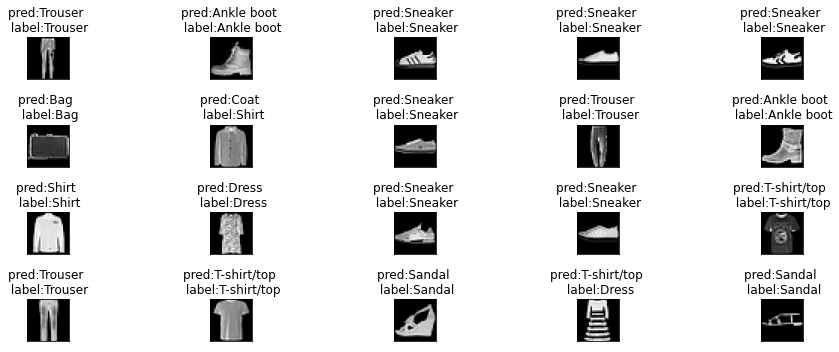

In [21]:
# VERIFICANDO RESULTADOS DO MODELO
dataiter = iter(test_loader)
images, labels = dataiter.next()
output= model (images)

fig= plt.figure(figsize=(15,5))
rous = 4
columns = 5

_ ,predictions = torch.max(output,1)
images = images.numpy()

for idx in np.arange(20):
  ax= fig.add_subplot(rous,columns,idx + 1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title('pred:{} \n label:{}'.format(fashion_classes[predictions[idx].item()], fashion_classes[labels[idx].item()]))
  fig.tight_layout()